# ResNet34
## Training stage 1

#### *Note before starting: 
`ImageCleaner` does not work in JupyterLab, but it *does* work in Jupyter Notebook

In [1]:
from fastai.vision import *
from fastai.widgets import *

In [2]:
np.random.seed(22)

In [3]:
path = Path('data')

Set transforms to augment the data. <br>
Set batch size.

In [4]:
tfms = get_transforms(max_rotate=25., max_zoom=1.25, max_lighting=0.4, max_warp=0.3, p_affine=0.85)
bs = 64

Create DataBunch `.from_csv` to include the cleaned up data set. <br>

In [23]:
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.15, csv_labels='cleaned.csv',
        ds_tfms=tfms, size=224, bs=bs, num_workers=4).normalize(imagenet_stats)

In [24]:
len(data.train_ds), len(data.valid_ds)

(641, 112)

In [28]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy, wd=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


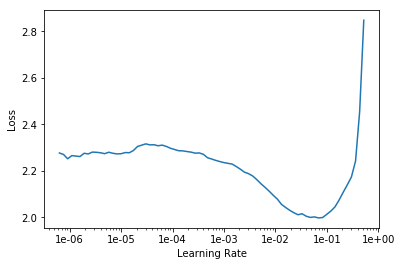

In [29]:
learn.lr_find()
learn.recorder.plot()

Train final layer exclusively

In [30]:
learn.fit_one_cycle(10, max_lr=2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.206449,1.651306,0.366071,00:04
1,1.925762,2.003698,0.339286,00:04
2,1.777230,2.733638,0.276786,00:04
3,1.762242,2.184550,0.250000,00:05
4,1.745272,2.772121,0.178571,00:05
5,1.678112,1.820547,0.375000,00:04
6,1.611329,1.603365,0.473214,00:04
7,1.524768,1.423286,0.482143,00:04
8,1.444434,1.399508,0.508929,00:04
9,1.362669,1.391134,0.482143,00:04


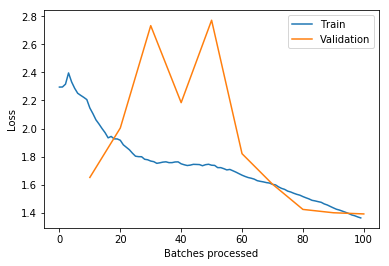

In [31]:
learn.recorder.plot_losses()

In [32]:
# Saves weights in data/models
learn.save('res34-stage-1')

# Training stage 2

### Train all layers

In [33]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


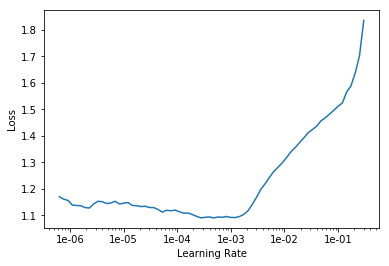

In [34]:
learn.lr_find()
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,2e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.090793,1.369748,0.464286,00:05
1,1.121889,1.363529,0.482143,00:05
2,1.094277,1.341551,0.491071,00:05
3,1.054717,1.373047,0.500000,00:06
4,1.013658,1.344361,0.508929,00:05
5,0.976986,1.333879,0.526786,00:05
6,0.939435,1.331366,0.553571,00:05
7,0.916285,1.331828,0.544643,00:05
8,0.898843,1.330823,0.544643,00:05
9,0.874476,1.322694,0.553571,00:05


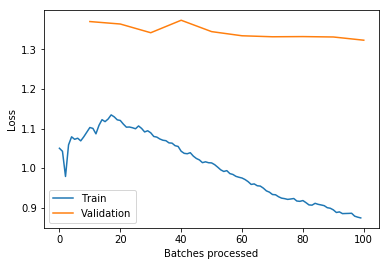

In [36]:
learn.recorder.plot_losses()

In [37]:
learn.save('res34-stage-2')

# Interpretation - ResNet34

In [20]:
# learn.load('res34-stage-2');

In [38]:
interp = ClassificationInterpretation.from_learner(learn)

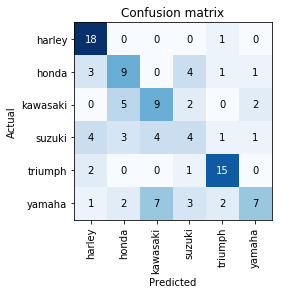

In [40]:
interp.plot_confusion_matrix()

----

# Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

####  `ImageCleaner` does not work in JupyterLab, but it does work in Jupyter Notebook

Note that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

#### First the Validation Set:

In [41]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

In [42]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

#### Now the Training Set:

In [43]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Train)

In [44]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

---

# ResNet50
## Training stage 1

#### Recreate the ImageDataBunch from the `cleaned.csv` to include the changes

Since the `cleaned.csv` file has changed, we will not end up with the exact same train/valid split. Therefore, our current model will have already been trained on images that will be in the new validation set. 

Let's start with a fresh learner with ResNet50 architecture and see if the results improve.

In [5]:
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.15, csv_labels='cleaned.csv',
        ds_tfms=tfms, size=224, bs=bs, num_workers=4).normalize(imagenet_stats)

In [6]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, wd=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


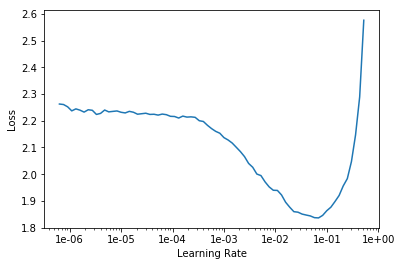

In [7]:
learn.lr_find()
learn.recorder.plot()

Train final layer exclusively

In [8]:
learn.fit_one_cycle(10, max_lr=2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.222654,1.818195,0.273684,00:08
1,1.867987,2.201182,0.347368,00:06
2,1.729716,2.594429,0.189474,00:06
3,1.687777,2.119642,0.305263,00:06
4,1.666340,1.868143,0.305263,00:06
5,1.592164,2.576033,0.242105,00:07
6,1.533493,2.057879,0.284211,00:06
7,1.444906,1.626415,0.431579,00:06
8,1.358804,1.431355,0.473684,00:06
9,1.299003,1.394280,0.515789,00:06


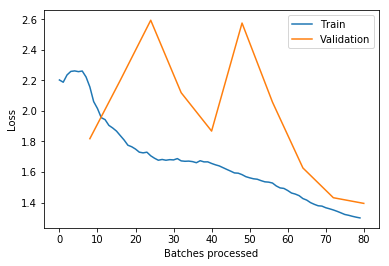

In [12]:
learn.recorder.plot_losses()

In [13]:
learn.save('res50-stage-1')

# Training stage 2

### Train all layers

In [14]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


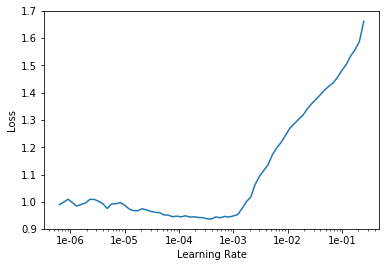

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.009144,1.396247,0.494737,00:08
1,0.968856,1.387365,0.526316,00:08
2,0.953671,1.403082,0.484211,00:08
3,0.933189,1.434034,0.505263,00:08
4,0.921412,1.406338,0.505263,00:08
5,0.896865,1.385789,0.484211,00:08
6,0.888842,1.377065,0.494737,00:08
7,0.872825,1.383333,0.494737,00:08
8,0.853570,1.380698,0.494737,00:08
9,0.837111,1.390996,0.505263,00:08


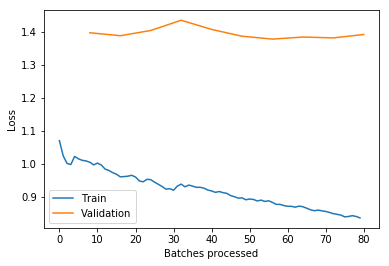

In [17]:
learn.recorder.plot_losses()

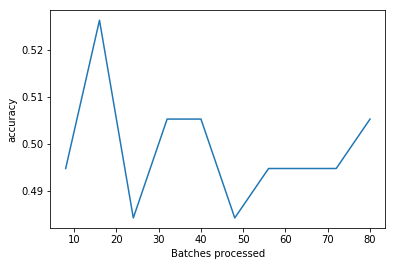

In [18]:
learn.recorder.plot_metrics()

In [19]:
learn.save('res50-stage-2')

# Interpretation - ResNet50

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

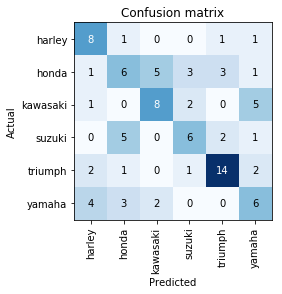

In [21]:
interp.plot_confusion_matrix()